In [1]:
import numpy as np
import pandas as pd
from SWMM import SWMM_ENV as SWMM_ENV
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import yaml

import datetime

from MPC import pso
import pyswmm
from swmm_api.input_file import read_inp_file
from pyswmm import Simulation,Links,Nodes,RainGages,SystemStats
from swmm_api.input_file.sections.others import TimeseriesData
from swmm_api.input_file.sections import Control
from swmm_api.input_file.section_labels import TIMESERIES, CONTROLS
from swmm_api import read_rpt_file, SwmmReport

# Rainfall

In [2]:
raindata = np.load('./rainfall/normlized_rainfall.npy',allow_pickle=True).tolist()
#erd = np.load('rainfall\\design_rainfall\\test_raindata.npy').tolist()
#exraindata = np.load('./rainfall/normlized_extended_rainfall.npy',allow_pickle=True).tolist()
exraindata = np.load('./rainfall/normlized_realrainfall.npy',allow_pickle=True).tolist()

In [ ]:
# 保存降雨的代码，不需要运行
def rain_op(data):    
    Hs = []
    delta,dura = 1, len(data)
    for i in range(dura//delta):
        Hs.append(data[i])
    tsd = Hs
    ts = []
    for i in range(dura//delta):
        t = i*delta
        key = '08/28/2015 '+str(9+t//60).zfill(2)+':'+str(t % 60).zfill(2)+':'+'00'#'08/28/2015 '+str(9+t//60).zfill(2)+':'+str(t % 60).zfill(2)+':'+'00'
        ts.append([key,tsd[i]])
    return ts

raindata = []
for i in range(len(rd)):
    tem =[]
    for j in rd[i]:
        tem.append(str(float(j[1])/10))
    temrd = rain_op(tem)
    raindata.append(temrd)

exraindata = []
for i in range(len(erd)):
    tem =[]
    for j in erd[i]:
        tem.append(str(float(j[1])/10))
    temrd = rain_op(tem)
    exraindata.append(temrd)

np.save('./rainfall/normlized_rainfall.npy',raindata)
np.save('./rainfall/normlized_extended_rainfall.npy',exraindata)

In [3]:
# selected rainfall for test
test_rainfall_id = [20,120,220,320,420,520,620,720,820,920]
np.save('./rainfall/testRainID.npy',test_rainfall_id)
test_rainfall_id = np.load('./rainfall/testRainID.npy',allow_pickle=True).tolist()
print(test_rainfall_id)

[20, 120, 220, 320, 420, 520, 620, 720, 820, 920]


# 寻优使用模型，给定降雨，带入swmm，最优化调整全程控制

## 读取结果使用函数

In [4]:
def step_results(sim,config,params,results):
    #获取模拟结果
    nodes = Nodes(sim)
    links = Links(sim)
    rgs = RainGages(sim)
    sys = SystemStats(sim)

    #obtain states and reward term by yaml (config)
    states = []
    for _temp in config["states"]:
        if _temp[1] == 'depthN':
            states.append(nodes[_temp[0]].depth)
        elif _temp[1] == 'flow':
            states.append(links[_temp[0]].flow)
        elif _temp[1] == 'inflow':
            states.append(nodes[_temp[0]].total_inflow)
        else:
            states.append(rgs[_temp[0]].rainfall)
        
    #获取reward和结果
    results, reward = SWMM_ENV.get_step_results(results,nodes,links,rgs,sys,config,params)
    results['state'].append(states)
    results['rewards'].append(reward)
    #results['action'].append(action)
      
    return states,reward,results

def trans_action(data):    
    ts = []
    for i in range(len(data)):
        t = i
        key = '01/01/2000 '+str(8+t*5//60).zfill(2)+':'+str((t*5) % 60).zfill(2)+':'+'00'
        ts.append([key,data[i]])
    return ts

In [5]:
# env参数
st = 'SWMM\\chaohu'

env_params = {
    'orf':st,
    'orf_save':'chaohu_RTC',# opt中使用不同的inp计算，上两个参数没有用到
    'parm':'states_yaml\\chaohu',
    'advance_seconds':300,
    'kf':1,
    'kc':1,
    'reward_type':'3',
}
config = yaml.load(open(env_params['parm']+".yaml"), yaml.FullLoader)

# pop优化算法参数
pop_param = {
    'pop_size':15,
    'max_value':15,
    'pc':0.6,
    'pm':0.5,
    'optstep':100,
}
action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:].tolist()

# OPT control

In [8]:
class PSO(object):
    def __init__(self, population_size, 
                       max_steps, 
                       calculate_fitness,
                       control_d, w, c,
                       x_bound,
                       rainid,rainname,config,env_params,pop_param):
        self.w = w  # 惯性权重
        self.c1 = self.c2 = c  # 加速常数
        self.population_size = population_size  # 粒子群数量
        self.dim = control_d  # 搜索空间的维度
        self.max_steps = max_steps  # 迭代次数
        #self.x_bound = [-1, 1]  # 解空间范围
        # 使用上一时刻数据限定解空间范围
        self.x_bound = x_bound
        self.x = np.random.randint(0,self.x_bound,
                                   (self.population_size, self.dim))  # 初始化粒子群位置
        self.v = np.random.rand(self.population_size, self.dim)  # 初始化粒子群速度

        self.calculate_fitness=calculate_fitness
        self.rainid, self.rainname, self.config, self.env_params, self.pop_param = rainid, rainname,config,env_params,pop_param
        fitness = np.array(self.calculate_fitness(self.x,
                                             self.rainid,
                                             self.rainname,
                                             self.config,
                                             self.env_params,
                                             self.pop_param))
        self.p = self.x.copy()  # 个体的最佳位置
        self.pg = self.x[np.argmax(fitness)]  # 全局最佳位置
        self.individual_best_fitness = fitness  # 个体的最优适应度
        self.global_best_fitness = np.max(fitness)  # 全局最佳适应度

    def evolve(self):
        self.best_fit_curv=[]
        for step in range(self.max_steps):
            r1 = np.random.rand(self.population_size,self.dim)
            r2 = np.random.rand(self.population_size,self.dim)
            # 更新速度和权重
            self.v = self.w * self.v + self.c1 * r1 * (self.p - self.x) + self.c2 * r2 * (self.pg - self.x)
            self.x = np.int16(np.round(np.clip(self.v[0] + self.x, 0, self.x_bound)))
            fitness = np.array(self.calculate_fitness(self.x,
                                             self.rainid,
                                             self.rainname,
                                             self.config,
                                             self.env_params,
                                             self.pop_param))
            # 需要更新的个体
            update_id = np.greater(fitness,self.individual_best_fitness)
            self.p[update_id] = self.x[update_id]
            self.individual_best_fitness[update_id] = fitness[update_id]
            # 新一代出现了更大的fitness，所以更新全局最优fitness和位置
            if np.max(fitness)> self.global_best_fitness:
                self.pg = self.x[np.argmax(fitness)]    
                self.global_best_fitness = np.max(fitness)
            self.best_fit_curv.append(self.global_best_fitness)
            
            #渐进终止条件
            if step>50:
                if np.sum(self.best_fit_curv[-10:])-np.sum(self.best_fit_curv[-20:-10])<0.00001:
                    break
        np.save('./OPT_results/opt_curve_'+self.rainname+str(self.rainid),self.best_fit_curv)

In [9]:
def calobjValue_mp(actions_set,rainid,rainname,config,env_params,pop_param):
    action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]

    def interact(at,coreid,rainid,rainname,config,env_params):

        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        
        # 带有降雨和coreid的inp
        inp = read_inp_file('./SWMM/_temopt_original/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        # action转化为inp使用的action，action放入SWMM（mp）
        ta={}
        for i in range(6):
            ta['pump'+str(i)] = []
            for t in at:
                pump_action = action_table[t].tolist()
                ta['pump'+str(i)].append(pump_action[i])
            inp[TIMESERIES]['pump'+str(i)]=TimeseriesData('pump'+str(i),trans_action(ta['pump'+str(i)]))
        
        inp.write_file('./SWMM/_temopt/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        sim_tem = Simulation('./SWMM/_temopt/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        # 读取模拟
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,config,env_params,results)
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()
        # 统计评分
        reward = np.sum(results['rewards'])
        return reward
    
    obj_value = Parallel(n_jobs=pop_param['pop_size'])(delayed(interact)(actions_set[i],i,rainid,rainname,config,env_params) for i in range(len(actions_set)))
    #obj_value = []
    #print(actions_set[0])
    #for i in range(pop_param['pop_size']):
    #    obj_value.append(interact(actions_set[:,i],i,rainid,rainname,config,env_params))
    return obj_value


def opt(rainid,rainname,pop_param,config,env_params):
    pso_obj = PSO(pop_param['pop_size'],
                  pop_param['optstep'],
                  calobjValue_mp,
                  95,0.6,0.5,
                  pop_param['max_value'],
                  rainid,rainname,config,env_params,pop_param)

    pso_obj.evolve()
    best_individual, best_fit = pso_obj.pg, pso_obj.global_best_fitness
    return best_individual, best_fit

In [10]:
def save_actionOPT(best_individual):
    action = []
    action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
    for it in best_individual:
        action.append(action_table[it].tolist())
    
    return action

In [12]:
rules = """
RULE R0
IF SIMULATION TIME > 0
THEN PUMP CC-R1 SETTING = TIMESERIES pump0

RULE R1
IF SIMULATION TIME > 0
THEN PUMP CC-R1 SETTING = TIMESERIES pump1

RULE R2
IF SIMULATION TIME > 0
THEN PUMP CC-S1 SETTING = TIMESERIES pump2

RULE R3
IF SIMULATION TIME > 0
THEN PUMP CC-S1 SETTING = TIMESERIES pump3

RULE R4
IF SIMULATION TIME > 0
THEN PUMP JK-R1 SETTING = TIMESERIES pump4

RULE R5
IF SIMULATION TIME > 0
THEN PUMP JK-R2 SETTING = TIMESERIES pump5

RULE R6
IF SIMULATION TIME > 0
THEN PUMP JK-S SETTING = TIMESERIES pump6
"""

In [14]:
class MPC_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,rules,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu.inp')
        #加入降雨
        inp[TIMESERIES]['rainfall']=TimeseriesData('rainfall',raindata[self.rainid])

        #加入控制title
        control_section = Control.create_section(rules)
        inp[CONTROLS]=control_section
        # 用于优化的inp
        for coreid in range(15):
            inp.write_file('./SWMM/_temopt_original/chaohu_core' + str(coreid) + '_' + self.rainname + str(self.rainid)+'.inp')
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/chaohu_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        best_individual, best_fit = opt(self.rainid,self.rainname,self.pop_param,self.config,self.env_params)

        # 输出带action的input，并模拟，并保存结果
        # 带有降雨和coreid的inp
        inp = read_inp_file('./SWMM/_temopt_original/chaohu_' + self.rainname + str(self.rainid)+'.inp')
        # action转化为inp使用的action，action放入SWMM（mp）
        ta={}
        for i in range(self.action_table.shape[1]):
            ta['pump'+str(i)] = []
            for t in best_individual:
                pump_action = self.action_table[t].tolist()
                ta['pump'+str(i)].append(pump_action[i])
            inp[TIMESERIES]['pump'+str(i)]=TimeseriesData('pump'+str(i),trans_action(ta['pump'+str(i)]))
        
        inp.write_file('./SWMM/_temopt_original/Sim_chaohu_'+self.rainname+str(self.rainid)+'.inp')
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/Sim_chaohu_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        results['action']=save_actionOPT(best_individual)
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [17]:
# extended rainfall
for i in range(len(exraindata)):
    print(i)
    optsys = MPC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(rules,exraindata)
    results = optsys.opt_mp()
    np.save('./OPT_results/extended_opt_results_rain'+str(i),results)

0
1
2


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3
4


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


5


In [41]:
for i in range(91):
    optsys = MPC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(rules,raindata)
    results = optsys.opt_mp()
    np.save('./OPT_results/opt_results_rain'+str(i),results)

0


# Benchmark Do-nothing control

In [6]:
action_table = pd.read_csv('./SWMM/action_table.csv').values[:,1:]
def save_DNaction(state):

    def rule(s,l1,l2,abar):
        if s >= l1:
            atem = 1.0
        elif s < l1 and s > l2:
            if abar == 0.0:
                atem = 0.0
            else:
                atem = 1.0
        else:
            atem = 0.0
        return atem
    
    action,action_index = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],[[0]]
    clevel = [[0.02,0.01],[0.02,0.01],[0.02,0.01],[0.02,0.01]]
    jlevel = [[0.02,0.01],[0.02,0.01],[0.02,0.01]]

    #clevel = [[0.05,0.01],[0.05,0.01],[0.025,0.01],[0.025,0.01]]
    #jlevel = [[0.1,0.01],[0.1,0.01],[0.05,0.01]]
    for s in state:
        atem=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        # CC-storage
        for i in range(len(clevel)):
            atem[i] = rule(s[0],clevel[i][0],clevel[i][1],action[-1][i])
        
        # JK-storage
        for i in range(len(jlevel)):
            atem[i+4] = rule(s[1],jlevel[i][0],jlevel[i][1],action[-1][i+4])
        action.append(atem)
        tem = 0
        for it in range(action_table.shape[0]):
            if (action_table[it] == np.array(atem)).all():
                tem = it
        action_index.append(tem)
    return action,action_index

class DN_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu_DN.inp')
        #加入降雨
        inp[TIMESERIES]['rainfall']=TimeseriesData('rainfall',raindata[self.rainid])
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/DN/chaohu_DN_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/DN/chaohu_DN_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        results['action'],action_index=save_DNaction(results['state'][1:])
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [13]:
# extended rainfall
for i in range(len(exraindata)):
    optsys = DN_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./DN_results/extended_dn_results_rain'+str(i),results)

for i in range(91):
    optsys = DN_sim(i,'design',env_params,pop_param,config)
    optsys.reset(raindata)
    results = optsys.opt_mp()
    np.save('./DN_results/DN_results_rain'+str(i),results)

In [7]:
for i in range(len(exraindata)):
    optsys = DN_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./DN_results/real_dn_results_rain'+str(i),results)

# K2: DNv2 control

In [8]:
action_table = pd.read_csv('./SWMM/action_table.csv').values[:,1:]
def save_DNv2action(state):

    def rule(s,l1,l2,abar):
        if s >= l1:
            atem = 1.0
        elif s < l1 and s > l2:
            if abar == 0.0:
                atem = 0.0
            else:
                atem = 1.0
        else:
            atem = 0.0
        return atem

    action,action_index = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],[[0]]
    clevel = [[0.03,0.01],[0.03,0.01],[0.025,0.01],[0.025,0.01]]
    jlevel = [[0.05,0.01],[0.05,0.01],[0.025,0.01]]

    #clevel = [[0.05,0.01],[0.05,0.01],[0.025,0.01],[0.025,0.01]]
    #jlevel = [[0.1,0.01],[0.1,0.01],[0.05,0.01]]
    for s in state:
        atem=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        # CC-storage
        for i in range(len(clevel)):
            atem[i] = rule(s[0],clevel[i][0],clevel[i][1],action[-1][i])
        
        # JK-storage
        for i in range(len(jlevel)):
            atem[i+4] = rule(s[1],jlevel[i][0],jlevel[i][1],action[-1][i+4])
        action.append(atem)
        tem = 0
        for it in range(action_table.shape[0]):
            if (action_table[it] == np.array(atem)).all():
                tem = it
        action_index.append(tem)
    return action,action_index

In [9]:
class DNv2_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu_DNv2.inp')
        #加入降雨
        inp[TIMESERIES]['rainfall']=TimeseriesData('rainfall',raindata[self.rainid])
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/DNv2/chaohu_DNv2_' + self.rainname + str(self.rainid)+'.inp')

    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/DNv2/chaohu_DNv2_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        _,results['action']=save_DNv2action(results['state'][1:])
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [17]:
# extended rainfall
for i in range(len(exraindata)):
    optsys = DNv2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./DNv2_results/extended_dnv2_results_rain'+str(i),results)

for i in range(91):
    optsys = DNv2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(raindata)
    results = optsys.opt_mp()
    np.save('./DNv2_results/DNv2_results_rain'+str(i),results)

In [10]:
for i in range(len(exraindata)):
    optsys = DNv2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./DNv2_results/real_dnv2_results_rain'+str(i),results)

# K3: Benchmark BC control

In [11]:
action_table = pd.read_csv('./SWMM/action_table.csv').values[:,1:]
def save_BCaction(state):

    def rule(s,l1,l2,abar):
        if s >= l1:
            atem = 1.0
        elif s < l1 and s > l2:
            if abar == 0.0:
                atem = 0.0
            else:
                atem = 1.0
        else:
            atem = 0.0
        return atem

    action,action_index = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],[[0]]
    clevel = [[1.2,0.5],[1.4,0.5],[0.8,0.5],[1,0.5]]
    jlevel = [[4.2,1.2],[4.3,1.2],[4,1]]
    for s in state:
        atem=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        # CC-storage
        for i in range(len(clevel)):
            atem[i] = rule(s[0],clevel[i][0],clevel[i][1],action[-1][i])
        
        # JK-storage
        for i in range(len(jlevel)):
            atem[i+4] = rule(s[1],jlevel[i][0],jlevel[i][1],action[-1][i+4])
        action.append(atem)
        tem = 0
        for it in range(action_table.shape[0]):
            if (action_table[it] == np.array(atem)).all():
                tem = it
        action_index.append(tem)
    return action,action_index

In [12]:
class BC_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu.inp')
        #加入降雨
        inp[TIMESERIES]['rainfall']=TimeseriesData('rainfall',raindata[self.rainid])
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/BC/chaohu_BC_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/BC/chaohu_BC_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        _,results['action']=save_BCaction(results['state'][1:])#BC记录T1水位反推action
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [20]:
# extended rainfall
for i in range(len(exraindata)):
    optsys = BC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./BC_results/extended_bc_results_rain'+str(i),results)

for i in range(91):
    optsys = BC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(raindata)
    results = optsys.opt_mp()
    np.save('./BC_results/bc_results_rain'+str(i),results)

In [13]:
for i in range(len(exraindata)):
    optsys = BC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./BC_results/real_bc_results_rain'+str(i),results)

# K4: BC2

In [14]:
action_table = pd.read_csv('./SWMM/action_table.csv').values[:,1:]
def save_BC2action(state):

    def rule(s,l1,l2,abar):
        if s >= l1:
            atem = 1.0
        elif s < l1 and s > l2:
            if abar == 0.0:
                atem = 0.0
            else:
                atem = 1.0
        else:
            atem = 0.0
        return atem

    action,action_index = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],[[0]]
    clevel = [[0.1,0.01],[0.1,0.01],[0.05,0.01],[0.05,0.01]]
    jlevel = [[0.4,0.01],[0.4,0.01],[0.2,0.01]]
    for s in state:
        atem=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        # CC-storage
        for i in range(len(clevel)):
            atem[i] = rule(s[0],clevel[i][0],clevel[i][1],action[-1][i])
        
        # JK-storage
        for i in range(len(jlevel)):
            atem[i+4] = rule(s[1],jlevel[i][0],jlevel[i][1],action[-1][i+4])
        action.append(atem)
        tem = 0
        for it in range(action_table.shape[0]):
            if (action_table[it] == np.array(atem)).all():
                tem = it
        action_index.append(tem)
    return action,action_index

In [15]:
class BC2_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu_BC2.inp')
        #加入降雨
        inp[TIMESERIES]['rainfall']=TimeseriesData('rainfall',raindata[self.rainid])
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/BC2/chaohu_BC2_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/BC2/chaohu_BC2_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        _,results['action']=save_BC2action(results['state'][1:])#BC记录T1水位反推action
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [23]:
# extended rainfall
for i in range(len(exraindata)):
    optsys = BC2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./BC2_results/extended_bc2_results_rain'+str(i),results)

for i in range(91):
    optsys = BC2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(raindata)
    results = optsys.opt_mp()
    np.save('./BC2_results/bc2_results_rain'+str(i),results)

In [16]:
for i in range(len(exraindata)):
    optsys = BC2_sim(i,'design',env_params,pop_param,config)
    optsys.reset(exraindata)
    results = optsys.opt_mp()
    np.save('./BC2_results/real_bc2_results_rain'+str(i),results)

# Compare

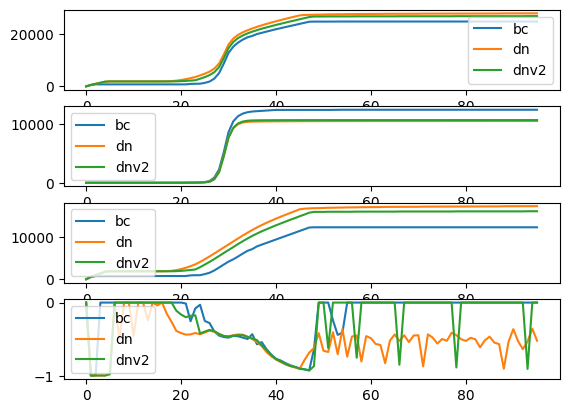

In [68]:
rainid = str(4)
reb = np.load('./BC_results/bc_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
ree = np.load('./DN_results/dn_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
red = np.load('./DNv2_results/dnv2_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
figs,ax = plt.subplots(4,1)
ax[0].plot(np.array(reb['flooding'])+np.array(reb['CSO']),label='bc')
ax[0].plot(np.array(ree['flooding'])+np.array(ree['CSO']),label='dn')
ax[0].plot(np.array(red['flooding'])+np.array(red['CSO']),label='dnv2')
ax[0].legend()

ax[1].plot(np.array(reb['flooding']),label='bc')
ax[1].plot(np.array(ree['flooding']),label='dn')
ax[1].plot(np.array(red['flooding']),label='dnv2')
ax[1].legend()

ax[2].plot(np.array(reb['CSO']),label='bc')
ax[2].plot(np.array(ree['CSO']),label='dn')
ax[2].plot(np.array(red['CSO']),label='dnv2')
ax[2].legend()

ax[3].plot(reb['rewards'],label='bc')
ax[3].plot(ree['rewards'],label='dn')
ax[3].plot(red['rewards'],label='dnv2')
ax[3].legend()

In [67]:
a = np.array(reb['flooding'])+np.array(reb['CSO'])
b = np.array(ree['flooding'])+np.array(ree['CSO'])
b = np.array(red['flooding'])+np.array(red['CSO'])
print(a[-1],b[-1])

24891.731180463095 26970.82081445254
